In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


In [12]:
# d_sae
f_acts = torch.ones(sae.W_dec.shape[0]) * torch.norm(sae.encode(base_ref.act), dim=-1).item()
# d_sae, d_sae
all_f_acts = torch.diag(f_acts)
# d_sae, d_model
dec_f_acts = all_f_acts @ sae.W_dec + sae.b_dec
# d_sae, d_sae
recon_f_acts = torch.relu((dec_f_acts - sae.b_dec) @ sae.W_enc + sae.b_enc)

n_all_f_acts = torch.sum((all_f_acts / all_f_acts.max(dim=-1, keepdim=True)[0]) > 0.05, dim=-1)
print(n_all_f_acts)
n_recon_f_acts = torch.sum((recon_f_acts / recon_f_acts.max(dim=-1, keepdim=True)[0]) > 0.05, dim=-1)
max_all_f_acts = all_f_acts.max(dim=-1)[1]
max_recon_f_acts = recon_f_acts.max(dim=-1)[1]

clean_f_idxs = []
for i in range(sae.W_dec.shape[0]):
    if max_all_f_acts[i] == max_recon_f_acts[i] and n_recon_f_acts[i] - n_all_f_acts[i] == 0:
        clean_f_idxs.append(i)

print(len(clean_f_idxs))
print(clean_f_idxs)



tensor([1, 1, 1,  ..., 1, 1, 1])
1325
[93, 105, 144, 154, 180, 211, 217, 231, 235, 239, 266, 285, 287, 290, 291, 298, 320, 327, 340, 366, 373, 387, 415, 431, 451, 457, 488, 496, 513, 524, 551, 589, 595, 601, 621, 630, 635, 649, 659, 689, 704, 741, 747, 787, 844, 860, 880, 971, 982, 1012, 1025, 1051, 1053, 1055, 1067, 1089, 1096, 1112, 1134, 1141, 1182, 1183, 1221, 1228, 1245, 1257, 1264, 1270, 1281, 1295, 1298, 1299, 1302, 1309, 1310, 1316, 1338, 1339, 1349, 1371, 1376, 1390, 1406, 1423, 1425, 1446, 1464, 1488, 1496, 1526, 1590, 1591, 1613, 1628, 1631, 1668, 1677, 1690, 1722, 1723, 1728, 1752, 1798, 1812, 1842, 1847, 1885, 1896, 1899, 1901, 1961, 2015, 2019, 2049, 2054, 2067, 2087, 2113, 2116, 2123, 2126, 2157, 2171, 2229, 2267, 2331, 2337, 2348, 2361, 2367, 2374, 2399, 2402, 2404, 2406, 2423, 2428, 2465, 2481, 2500, 2517, 2527, 2537, 2553, 2563, 2589, 2590, 2595, 2637, 2651, 2691, 2700, 2716, 2719, 2727, 2757, 2764, 2776, 2789, 2796, 2812, 2821, 2848, 2998, 2999, 3026, 3049, 3060, 306

In [13]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation
from teren.utils import get_random_activation

In [14]:
base_feature_acts = sae.encode(base_ref.cache[sae.cfg.hook_name])[0, -1, :]
base_active_features = {feature_idx: base_feature_acts[feature_idx] for feature_idx in range(base_feature_acts.shape[0]) if base_feature_acts[feature_idx] / base_feature_acts.max() > 0.1}
recon_feature_acts = sae.encode(sae.decode(sae.encode(base_ref.cache[sae.cfg.hook_name])))[0, -1, :]
recon_active_features = {feature_idx: recon_feature_acts[feature_idx] for feature_idx in range(recon_feature_acts.shape[0]) if recon_feature_acts[feature_idx] / recon_feature_acts.max() > 0.1}
print(base_active_features)
print(recon_active_features)

{4955: tensor(4.4000), 6131: tensor(4.8369), 8379: tensor(24.3063), 11640: tensor(12.4796), 21958: tensor(3.8892), 24149: tensor(3.5142)}
{4955: tensor(3.6966), 6131: tensor(6.2245), 8379: tensor(23.2660), 11640: tensor(12.4375), 23959: tensor(2.9758)}


In [15]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, normalize=False):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    clean_features =  {f_idx: feature_acts[f_idx] for f_idx in random.sample(clean_f_idxs, 10) if f_idx not in active_features.keys()}
    
    orthogonal_features = {}
    clean_ortho_features = {}
    for f_idx in [i for i in range(sae.W_dec.shape[0]) if i not in active_features.keys()]:
        #if len(clean_ortho_features.keys()) == 5:
        #    break   
    
        not_ortho = False
        '''
        for af_idx in active_features.keys():
            cos_sim = torch.einsum("... k, ... k -> ... ", sae.W_dec[f_idx], sae.W_dec[af_idx])
            if cos_sim < 0.0 or cos_sim > 0.05:
                not_ortho = True
                break 
        '''
        cos_sim = torch.einsum("... k, ... k -> ... ", sae.W_dec[f_idx], (exp_ref.act.squeeze(0).squeeze(0))) / torch.norm(exp_ref.act.squeeze(0).squeeze(0))
        if cos_sim < 0.0 or cos_sim > 0.001:
                not_ortho = True

        if not not_ortho:
            if len(orthogonal_features.keys()) < 20:
                orthogonal_features[f_idx] = feature_acts[f_idx]
            if f_idx in clean_f_idxs:
                clean_ortho_features[f_idx] = feature_acts[f_idx]
                print(f"Number of Clean Orthogonal Features found: {len(clean_ortho_features.keys())}")

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]

    sorted_features = sorted(orthogonal_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):
        
        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )
        #target = sae.b_dec.unsqueeze(0).unsqueeze(0)

        #target = torch.zeros_like(exp_ref.act)

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=False)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=False)
        sae_control[i].append(sae_kl_div)
    
    for i in tqdm(range(len(sorted_features))):  
        saefeat_perturbation = SAEFeaturePerturbation(exp_ref, sorted_features[i], sae, negate=1)
        kl_div = run_perturbation(cfg, exp_ref, saefeat_perturbation, reduce=False, sae=sae)
        results[sorted_features[i][0]]['kl_div'] = kl_div
            
    #print(results.keys())
    #print(control.keys())

    assert [i[0] for i in sorted_features] == list(results.keys())

    feature_activation = torch.Tensor([feature[1] for feature in sorted_features])
    #print(feature_activation)

    recon_feature_dir = sae.W_dec[[feature[0] for feature in sorted_features]]
    feature_dot_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, exp_ref.act)  / torch.norm(exp_ref.act)
    #print(feature_act_dot)
    feature_dot_bias_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, (exp_ref.act)) / torch.norm((exp_ref.act))

    feature_sparsity = sparsity[list(results.keys())]
    #print(feature_sparsity)

    feature_dot_feature = []
    for feature in sorted_features:
        feature_dot_all = torch.einsum("...k, ... j k -> ... j", sae.W_dec[feature[0]], sae.W_dec[[feature_idx for feature_idx in active_features.keys() if feature_idx != feature[0]]])
        feature_dot_feature.append(feature_dot_all.min(dim=-1)[0])
    feature_dot_feature = torch.Tensor(feature_dot_feature)
    #print(feature_other)

    feature_cleanness = []
    for feature in sorted_features:
        f_act = torch.zeros_like(feature_acts)
        f_act[feature[0]] = torch.norm(exp_ref.act).item()
        recon_f_act = sae.encode(sae.decode(f_act))
        feature_cleanness.append(-1 * (recon_f_act - f_act).abs().sum())
    feature_cleanness = torch.Tensor(feature_cleanness)

    if normalize:
        for i, feature in enumerate(sorted_features):
            feature_activation[i] /= (feature_activation.max(dim=-1)[0])
            feature_dot_act[0][i] /= (feature_dot_act[0].max(dim=-1)[0])
            feature_dot_bias_act[0][i] /= (feature_dot_bias_act[0].max(dim=-1)[0])
            feature_sparsity[i] /= (feature_sparsity.abs().max(dim=-1)[0])
            feature_dot_feature[i] /= (feature_dot_feature.max(dim=-1)[0])
            feature_cleanness[i] /= (-1 * feature_cleanness.min(dim=-1)[0])

    for i, feature in enumerate(sorted_features):
        results[feature[0]]['Feature Activation'] = feature_activation[i]
        results[feature[0]]['Feature Dot Act'] = feature_dot_act[0][i]
        results[feature[0]]['Feature Dot Bias Act'] = feature_dot_bias_act[0][i]
        results[feature[0]]['Feature Sparsity'] = feature_sparsity[i]
        results[feature[0]]['Feature Dot Feature'] = feature_dot_feature[i]
        results[feature[0]]['Feature Cleanness'] = feature_cleanness[i]


    properties = {"Feature Activation": [feature_activation.min(dim=-1)[0].item(), feature_activation.max(dim=-1)[0].item()], 
                  "Feature Dot Act": [feature_dot_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_act.squeeze(0).max(dim=-1)[0].item()],
                  "Feature Dot Bias Act": [feature_dot_bias_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_bias_act.squeeze(0).max(dim=-1)[0].item()], 
                  "Feature Sparsity": [feature_sparsity.min(dim=-1)[0].item(), feature_sparsity.max(dim=-1)[0].item()], 
                  "Feature Dot Feature": [feature_dot_feature.min(dim=-1)[0].item(), feature_dot_feature.max(dim=-1)[0].item()],
                  "Feature Cleanness": [feature_cleanness.min(dim=-1)[0].item(), feature_cleanness.max(dim=-1)[0].item()]}

    return results, control, sae_control, properties


In [16]:
def plot_all_results(fig, ax, results, control, sae_control, properties):
    colors = plt.cm.viridis(np.linspace(0,1,len(results.keys())))

    for i, color_property in enumerate(properties.keys()):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

        plot_order = sorted(results.items(), key = lambda item: item[1][color_property])

        for j, (feature_idx, data) in enumerate(plot_order):
            kl_div = data['kl_div']
            ax[i][0].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][1].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)

        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        ax[i][0].set_xlim(0,100)
        #ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        ax[i][1].set_xlim(0,100)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][2].set_ylabel("KL divergence to base logits")
        #ax[i][2].set_xlim(0,75)
        #ax[i][2].set_ylim(-0.01,2)

        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
        cbar = fig.colorbar(sm, ax=ax[i][2])
        cbar.set_label(color_property)
    

In [17]:
our_prompt = "The capital of France is Paris"
our_tokens = torch.tensor([model.tokenizer.encode(our_prompt)])
cfg.n_ctx = our_tokens.shape[1]

In [18]:
new_prompt = torch.tensor([[ 938, 2121,   11,  607,  749, 1029]])

In [19]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt, torch.norm(exp_ref.act, dim=-1))
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 2
    results, controls, sae_controls, properties = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, normalize=False)

    if i == 0:
        all_results = results
        all_properties = properties                                     
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for f_idx, result in results.items():
            all_results[f_idx] = result 
        
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

        for property in properties.keys():
            all_properties[property][0] = min(properties[property][0], all_properties[property][0])
            all_properties[property][1] = max(properties[property][1], all_properties[property][1])
    print(all_properties)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 938, 2121,   11,  607,  749, 1029]]) tensor([[53.4467]])
Prompt:  last fall, her most high
Number of Clean Orthogonal Features found: 1
Number of Clean Orthogonal Features found: 2
Number of Clean Orthogonal Features found: 3
Number of Clean Orthogonal Features found: 4
Number of Clean Orthogonal Features found: 5
Number of Clean Orthogonal Features found: 6
Number of Clean Orthogonal Features found: 7
Number of Clean Orthogonal Features found: 8
Using 6 active features: {5735: tensor(25.0345), 15738: tensor(2.8676), 21958: tensor(3.0731), 23420: tensor(3.3922), 23577: tensor(3.8408), 24149: tensor(6.4901)}


Base Recon Error: 150.0970916748047
Target Recon Error: 266.32171630859375


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Base Recon Error: 150.0970916748047
Target Recon Error: 167.41307067871094


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([15.7690,  0.0000,  4.4155,  1.0880,  3.1947,  7.0648])
Number of active features post pert: 3


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([25.7272,  0.0000, 12.4527,  5.6441,  0.0000, 15.9087])
Number of active features post pert: 43


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([6.9861, 0.0000, 5.6945, 2.4100, 5.2138, 9.4817])
Number of active features post pert: 5


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([19.0554,  0.0000,  5.8233,  7.6327,  4.5302,  8.4608])
Number of active features post pert: 6


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([12.0218,  3.0959,  6.4359,  6.3072,  7.1378,  9.5585])
Number of active features post pert: 6


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([25.3555,  1.0186,  1.9382,  2.1603,  2.6672,  5.0727])
Number of active features post pert: 842


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([26.5126,  3.1603,  1.6037,  0.5034,  3.3718,  3.0249])
Number of active features post pert: 352


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([8.5667, 0.0000, 6.9953, 6.5176, 4.8885, 7.5136])
Number of active features post pert: 6


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([23.9628,  5.5367,  5.1907,  2.2614, 12.7237, 11.4199])
Number of active features post pert: 249


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([6.2150, 0.0000, 2.6526, 0.6700, 1.4032, 6.4371])
Number of active features post pert: 3


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([15.0762,  0.0000,  4.6583,  3.6508,  3.3007, 10.5327])
Number of active features post pert: 7


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([24.7220,  6.8146,  9.2179,  7.2884,  2.6961,  6.7079])
Number of active features post pert: 211


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([15.2321,  0.0000,  8.0147,  1.1551,  7.7422,  9.3238])
Number of active features post pert: 5


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([24.6082,  0.0000,  4.2739,  4.6673,  2.5247,  6.5677])
Number of active features post pert: 3


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([ 4.9627,  0.0000,  7.2692,  0.2519,  6.9729, 10.7489])
Number of active features post pert: 5


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([6.2164, 0.0000, 4.0308, 0.4941, 3.2092, 9.0337])
Number of active features post pert: 3


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([9.1685, 0.0000, 5.3927, 0.9356, 4.8934, 7.6838])
Number of active features post pert: 4


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([18.9285,  0.0000,  4.4428,  6.8591,  5.3381,  8.3812])
Number of active features post pert: 6


Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([32.6062,  0.0000,  0.0000,  0.0000, 15.4247, 10.1636])
Number of active features post pert: 924


100%|██████████| 1/1 [00:25<00:00, 25.09s/it]

Initial feature activations: tensor([25.0345,  2.8676,  3.0731,  3.3922,  3.8408,  6.4901])
Final feature activations: tensor([ 7.1872,  0.0000,  5.4130,  0.0000, 11.0073,  8.9240])
Number of active features post pert: 6
{'Feature Activation': [0.0, 0.0], 'Feature Dot Act': [1.544574297440704e-05, 0.0009400858543813229], 'Feature Dot Bias Act': [1.544574297440704e-05, 0.0009400858543813229], 'Feature Sparsity': [-10.0, -3.580144166946411], 'Feature Dot Feature': [-0.10051913559436798, 0.022550202906131744], 'Feature Cleanness': [-85024.2421875, -76.49462127685547]}


In [20]:
# interesting prompts
#tensor([[13566,  5985, 46380, 32680,   373,  4248]])
#Prompt:  Diamond Clean Toothbrush was £

#tensor([[ 250, 3792,  262, 6994, 5342, 4684]])
#Prompt: �Is the prime minister willing

#tensor([[  11, 4773,  531,   13,  383, 3155]])
#Prompt: , authorities said. The couple

#tensor([[  247,    82,  5743,  1871,  1450, 18045]])
#Prompt: �s edge among men jumps

#tensor([[ 821, 4858,   11,  484,  761,  284]])
#Prompt: 're massive, they need to

#tensor([[ 938, 2121,   11,  607,  749, 1029]])
#Prompt:  last fall, her most high

#tensor([[2912,  329, 9207,   11, 3387, 1317]]) tensor([[53.2254]])
#Prompt:  comment for publication, please mark


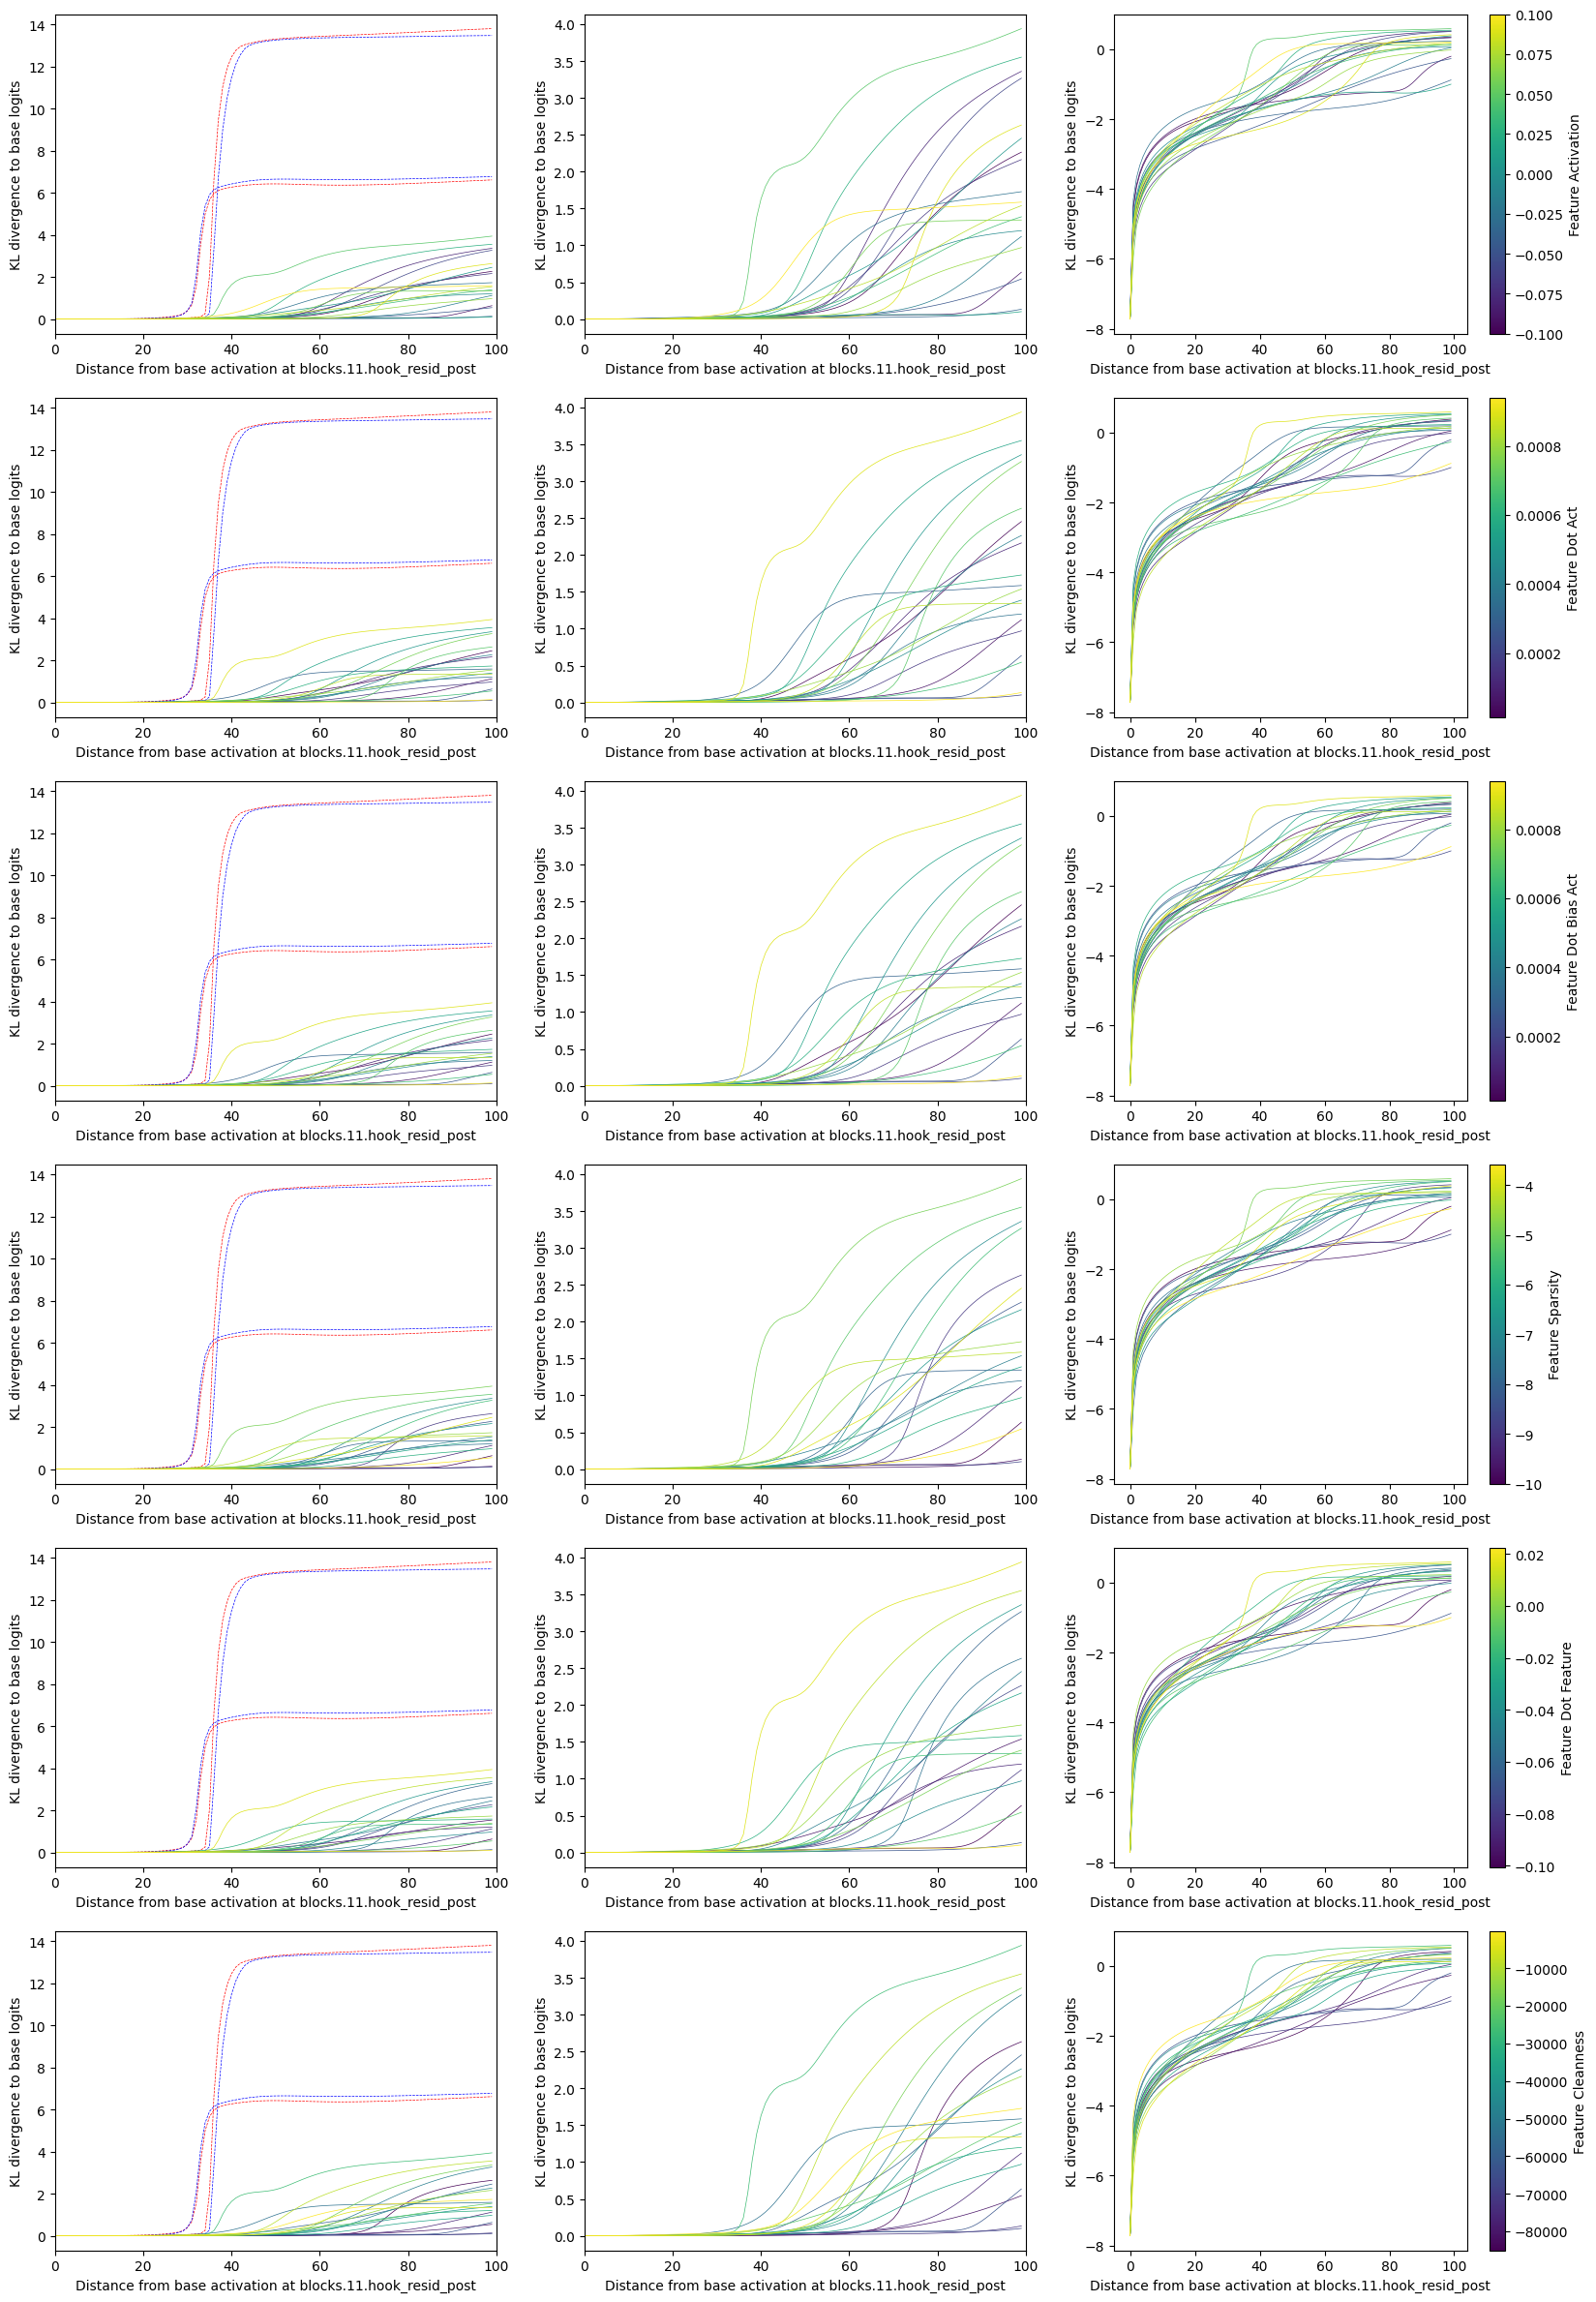

In [21]:
fig, ax = plt.subplots(len(properties.keys()), 3, figsize=(20,5*len(properties.keys())))

plot_all_results(fig, ax, all_results, all_controls, all_sae_controls, all_properties)
fig.show()

In [14]:
syn_cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=101,
    mean_batch_size=700,
)

In [15]:
# Examining SAE features
def get_syn_results_for_prompt(exp_ref, cfg, sae, n_control, n_syn, thresh, reduce=True):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(antiparallel_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    control = defaultdict(list)
    sae_control = defaultdict(list)
    for n in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[n].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce, sae=sae)
        sae_control[n].append(sae_kl_div)

    syn = defaultdict(list)
    syn_add = defaultdict(list)
    for n in tqdm(range(n_syn)):
        
        inactive_features = [f_idx for f_idx in range(sae.W_dec.shape[0]) if f_idx not in active_features.keys()]
        #target_f_idxs = random.sample(inactive_features, len(active_features.keys()))
        #target_f_idxs = random.choices(inactive_features, weights=(10**sparsity)[inactive_features].tolist(), k=len(active_features.keys()))
        
        candidate_features = {f_idx: [] for f_idx in active_features.keys()}
        for i in inactive_features:
            for j in active_features.keys():
                if (sparsity[i] - sparsity[j]).abs().item() < 0.01 and len(candidate_features[j]) <= 5:
                    candidate_features[j].append([i]) 
                    break
        
        target_f_idxs = []
        for i in active_features.keys():
            target_f_idxs.append(random.choice(candidate_features[i])[0])
        print(target_f_idxs)
        print(sparsity[list(active_features.keys())], sparsity[target_f_idxs])

        # Same feature activations as base act
        target_f_acts = torch.zeros_like(feature_acts)
        for i, f_act in enumerate(active_features.values()):
            target_f_acts[target_f_idxs[i]] = f_act

        # Distribute feature activations equally among target features
        eq_target_f_acts = torch.zeros_like(feature_acts)
        for f_idx in target_f_idxs:
            eq_target_f_acts[f_idx] = torch.norm(feature_acts, dim=-1) / len(target_f_idxs)

        rem_target_f_idxs = 

        print(f"Normal {n}")
        syn_activation_perturbation = SyntheticActivationPerturbation(exp_ref, dataset, sae, target_f_idxs, target_f_acts, additive=False)
        syn_kl_div = run_perturbation(cfg, exp_ref, syn_activation_perturbation, reduce=reduce, sae=sae, verbose=True)
        syn[n].append(syn_kl_div)

        print(f"Modified {n}")
        syn_add_activation_perturbation = SyntheticActivationPerturbation(exp_ref, dataset, sae, target_f_idxs, eq_target_f_acts, additive=False)
        syn_add_kl_div = run_perturbation(cfg, exp_ref, syn_add_activation_perturbation, reduce=reduce, sae=sae, verbose=True)
        syn_add[n].append(syn_add_kl_div)
    
    syn_abl = defaultdict(list)
    for i in active_features.keys():
        # Ablate selected features
        abl_f_acts = feature_acts.clone()
        abl_f_idxs = [i]
        for f_idx in abl_f_idxs:
            abl_f_acts[f_idx] = 0.0
            print(f"Ablated feature: {f_idx}, {active_features[f_idx]}")
        
        syn_abl_activation_perturbation = SyntheticActivationPerturbation(exp_ref, dataset, sae, abl_f_idxs, abl_f_acts, additive=False)
        syn_abl_kl_div = run_perturbation(cfg, exp_ref, syn_abl_activation_perturbation, reduce=reduce, sae=sae, verbose=True)
        syn_abl[i].append(syn_abl_kl_div)

    return control, sae_control, syn, syn_add, syn_abl


In [28]:
def plot_syn_results(fig, ax, control, sae_control, syn, syn_add, syn_abl):

    for i in range(3):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].loglog(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].loglog(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for syn_kl_div in syn.values():
        ax[0][0].plot(syn_kl_div[0], linewidth=1.0)
        ax[0][1].plot(syn_kl_div[0], linewidth=1.0)
        ax[0][2].loglog(syn_kl_div[0], linewidth=1.0)
    
    for syn_add_kl_div in syn_add.values():
        ax[1][0].plot(syn_add_kl_div[0], linewidth=1.0)
        ax[1][1].plot(syn_add_kl_div[0], linewidth=1.0)
        ax[1][2].loglog(syn_add_kl_div[0], linewidth=1.0)

    for syn_abl_kl_div in syn_abl.values():
        ax[2][0].plot(syn_abl_kl_div[0], linewidth=1.0)
        ax[2][1].plot(syn_abl_kl_div[0], linewidth=1.0)
        ax[2][2].loglog(syn_abl_kl_div[0], linewidth=1.0)

    for i in range(3):
        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Perturbation Step")
        ax[i][0].set_ylabel("KL divergence to base logits")
        #ax[i][0].set_xlim(0, 20)
        #ax[i][0].set_ylim(-0.1, 0.1)

        ax[i][1].set_xlabel(f"Perturbation Step")
        ax[i][1].set_ylabel("KL divergence to base logits")
        #ax[i][1].set_xlim(0, 361)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Perturbation Step")
        ax[i][2].set_ylabel("log10(KL divergence) to base logits")
        #ax[i][2].set_xlim(0, 180)
        #ax[i][2].set_ylim(-0.01, 2)
    

In [23]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    #exp_prompt = torch.tensor([[ 287, 2253, 1909,   13,  198,  198]])
    exp_ref = Reference(
        model,
        exp_prompt,
        syn_cfg.perturbation_layer,
        syn_cfg.read_layer,
        syn_cfg.perturbation_pos,
        syn_cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    
    n_control = 5
    n_syn = 5
    controls, sae_controls, syns, syn_adds, syn_abls = get_syn_results_for_prompt(exp_ref, syn_cfg, sae, n_control=n_control, n_syn=n_syn, thresh = 0.05, reduce=True)

    if i == 0:                                    
        all_controls = controls
        all_sae_controls = sae_controls
        all_syns = syns
        all_syn_adds = syn_adds
        all_syn_abls = syn_abls
    else:
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control
        
        for control_idx, syn in syns.items():
            all_syns[n_control*i+control_idx] = syn

        for control_idx, syn_add in syn_adds.items():
            all_syn_adds[n_control*i+control_idx] = syn_add
        
        for abl_idx, syn_abl in syn_abls.items():
            all_syn_abls[abl_idx*i+abl_idx] = syn_abl

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 250, 3792,  262, 6994, 5342, 4684,  284, 3015,  284, 3494]])
Prompt: �Is the prime minister willing to vote to implement
11704
10548
11704
12757
24189
12757
12757
Using 7 active features: {2244: tensor(2.1902), 9857: tensor(27.8871), 11588: tensor(2.0275), 17742: tensor(3.7444), 21958: tensor(5.7030), 23420: tensor(3.3746), 24149: tensor(5.7424)}


Base Recon Error: 189.6764373779297
Double Base Recon Error: 98.16908264160156
Target Recon Error: 147.10968017578125


Base Recon Error: 189.6764373779297
Double Base Recon Error: 98.16908264160156
Target Recon Error: 354.2132568359375


Base Recon Error: 189.6764373779297
Double Base Recon Error: 98.16908264160156
Target Recon Error: 438.7929992675781


Base Recon Error: 189.6764373779297
Double Base Recon Error: 98.16908264160156
Target Recon Error: 134.4432830810547


Base Recon Error: 189.6764373779297
Double Base Recon Error: 98.16908264160156
Target Recon Error: 170.23939514160156


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


[24318, 100, 23577, 20029, 19865, 16588, 6008]
tensor([-1.6346, -4.2250, -1.3209, -1.0481, -0.9500, -1.3411, -1.1227]) tensor([-1.6381, -4.2268, -1.3214, -1.0470, -0.9432, -1.3413, -1.1205])
Normal 0
Modified 0


[24318, 162, 6134, 20029, 12757, 17691, 17840]
tensor([-1.6346, -4.2250, -1.3209, -1.0481, -0.9500, -1.3411, -1.1227]) tensor([-1.6381, -4.2340, -1.3260, -1.0470, -0.9430, -1.3445, -1.1202])
Normal 1
Modified 1


[10326, 162, 22864, 482, 19865, 10652, 6008]
tensor([-1.6346, -4.2250, -1.3209, -1.0481, -0.9500, -1.3411, -1.1227]) tensor([-1.6368, -4.2340, -1.3178, -1.0532, -0.9432, -1.3335, -1.1205])
Normal 2
Modified 2


[20718, 162, 7538, 482, 19865, 16588, 17840]
tensor([-1.6346, -4.2250, -1.3209, -1.0481, -0.9500, -1.3411, -1.1227]) tensor([-1.6404, -4.2340, -1.3237, -1.0532, -0.9432, -1.3413, -1.1202])
Normal 3
Modified 3


[24318, 100, 11114, 20029, 12757, 1153, 17840]
tensor([-1.6346, -4.2250, -1.3209, -1.0481, -0.9500, -1.3411, -1.1227]) tensor([-1.6381, -4.2268, -1.3239, -1.0470, -0.9430, -1.3449, -1.1202])
Normal 4
Modified 4


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


Ablated feature: 2244, 2.1901803016662598
Ablated feature: 9857, 27.887128829956055
Ablated feature: 11588, 2.027456760406494
Ablated feature: 17742, 3.7443580627441406
Ablated feature: 21958, 5.703008651733398
Ablated feature: 23420, 3.374572277069092
Ablated feature: 24149, 5.742435455322266


100%|██████████| 1/1 [00:25<00:00, 25.35s/it]


In [24]:
#interesting prompts
#tensor([[ 287, 2253, 1909,   13,  198,  198]])
#Prompt:  in America today.

In [25]:
print(all_syns.keys())

dict_keys([0, 1, 2, 3, 4])


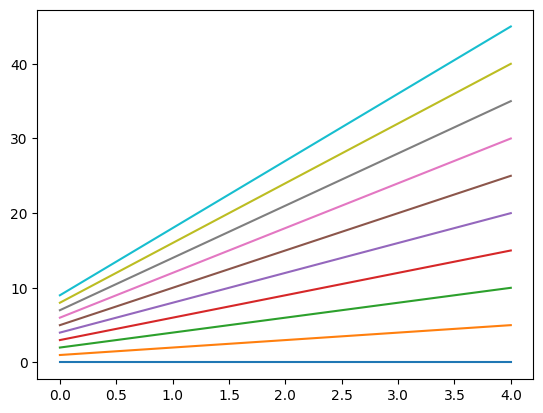

In [26]:
l = np.array([1,2,3,4,5])
for i in range(10):
    plt.plot(i*l)

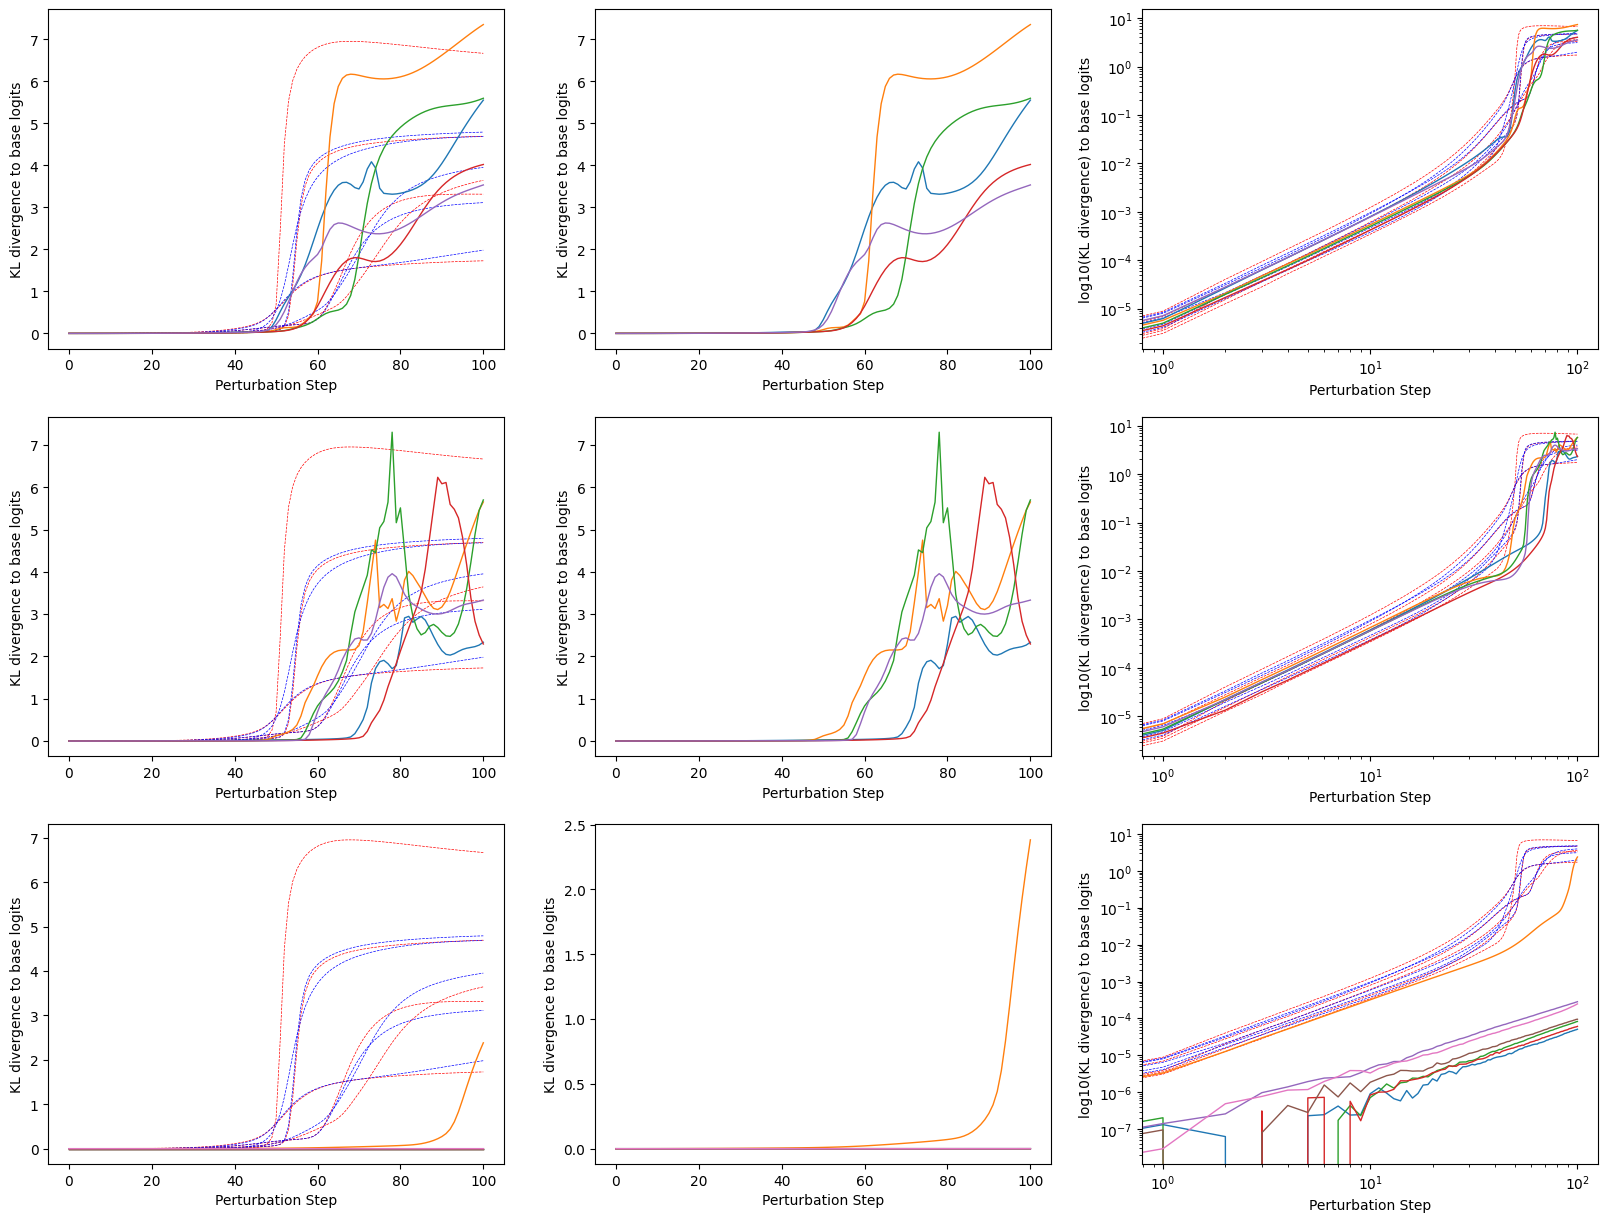

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(20,15))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds, all_syn_abls)
fig.show()